<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/image_classification/estonian_mushroom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
! pip install -q kaggle

In [ ]:
from fastai.vision.all import *

# Image Multiclass Classification

We will be entering this [Kaggle competition](https://www.kaggle.com/competitions/mushroom-multiclass-classification), which is a multiclass image classification project on Estonian mushrooms. The aim is to predict the type of mushroom to improve public safety and knowledge.

This project is an iterative approach to deep learning and I intend on trying a few different models to put forward multiple submissions.

## Data Extraction

Because we're working with a large image dataset that's too large to manually upload, I'm going to use the command line to manually download the dataset.

First, I need to store my Kaggle API credentials as a secret called `'KAGGLE_JSON'` which we can access using `userdata`. This will return the string which we can pass with `json.loads` and store into `os.environ` variables.

This will give our notebook access to the Kaggle competitions I have signed up for. If trying to use this notebook, make sure you follow similar steps:
1. Set secret in Google Colab with Kaggle API credentials.
2. Agree to competition rules for the mushroom classification competition ([Kaggle competition](https://www.kaggle.com/competitions/mushroom-multiclass-classification))

In [ ]:
import os, json
from google.colab import userdata

kaggle_json = json.loads(userdata.get('KAGGLE_JSON'))
os.environ["KAGGLE_USERNAME"] = kaggle_json["username"]
os.environ["KAGGLE_KEY"] = kaggle_json["key"]

In [ ]:
!kaggle competitions download -c mushroom-multiclass-classification

 89% 29.0M/32.5M [00:00<00:00, 38.9MB/s]
100% 32.5M/32.5M [00:01<00:00, 31.2MB/s]


Now, we can unzip the file to access our dataset.

In [ ]:
import zipfile

comp = 'mushroom-multiclass-classification'
with zipfile.ZipFile(f'{comp}.zip', 'r') as zip_ref:
    zip_ref.extractall(comp)

Upon inspection of the files, it appears that we have a bunch of images in a folder called `dataset`, then a `test.csv` and a `train.csv` file.

Let's inspect our csv files closer using pandas, the best library when working with csvs.

In [ ]:
import pandas as pd

df = pd.read_csv(f'{comp}/train.csv')
df_test = pd.read_csv(f'{comp}/test.csv')


In [ ]:
df_test.head()

,Image
0,2372
1,2373
2,2374
3,2375
4,2376


In [ ]:
df.head()

,Image,Mushroom
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


So, it seems that the CSV files specify which images are for training (as they have labels) and which images are for testing (to upload to Kaggle).

Now is a good time to introduce this information about the data. The mushrooms are labelled 0-9 and each number corresponds to the following mushroom type:

0. amanita
1. boletus
2. chantelle
3. deterrimus
4. rufus
5. torminosus
6. aurantiacum
7. procera
8. involutus
9. russula

We have 300 images for each category - 3000 images in total.

We need the `'Image'` column in dataframe to have the same format as the filenames. Since the filenames are in the format 00001.jpg, 00002.jpg, where the number is 5 digits long and padded with zeros, I will alter the dataframe to be the same.

This will enable the dataloaders to correctly classify the images for training.

In [ ]:
df['Image'] = df['Image'].apply(lambda x: f"{int(x):05d}.jpg")

I will also quickly check that we have no missing values in our dataframe - which we don't :)

In [ ]:
df.isnull().sum()

,0
Image,0
Mushroom,0


What I'm going to do, is move all the training images into one folder called `'train_images'` and all the test images into a different folder called '`test_images'` - then, I don't even need `df_test` anymore, as it contains no other useful information.

In [ ]:
import shutil

# define paths
image_folder = comp + "/dataset/dataset/"
train_folder = comp + "/dataset/train_images/"
test_folder = comp + "/dataset/test_images/"

# make folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# convert to lists with zero-padded filenames (this is how they are named)
train_images = df["Image"].astype(int).apply(lambda x: f"{x:05d}.jpg").tolist()
test_images = df_test["Image"].astype(int).apply(lambda x: f"{x:05d}.jpg").tolist()

# move images into respective folders
for img in train_images:
  src = os.path.join(image_folder, img)
  dst = os.path.join(train_folder, img)
  if os.path.exists(src):
    shutil.move(src, dst)

for img in test_images:
  src = os.path.join(image_folder, img)
  dst = os.path.join(test_folder, img)
  if os.path.exists(src):
    shutil.move(src, dst)

Let's inspect our images.

**Important note**: generally, when working with image libraries, including Pillow, images are measured columns by rows (the opposite of dataframes in Pandas or tensors in PyTorch).

(278, 181)


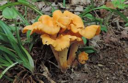

In [ ]:
files = get_image_files(train_folder)
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Looks like we're probably working with images of all different sizes. But we can use fastcore's `parallel` library to quickly find the size of all our images.

In [ ]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

,count
"(259, 194)",457
"(275, 183)",446
"(225, 225)",170
"(194, 259)",104
"(183, 275)",59
...,...
"(356, 141)",1
"(200, 133)",1
"(220, 156)",1
"(389, 129)",1


As expected, we have 262 different image sizes. This will be important to take into account when creating our Dataloaders.

## Baseline Model

We're going to start with a very easy and quick model using FastAI - this will give us an indication of how much our more advanced techniques help us out.

For now, we will transform our individual images into a square of 280px by 280px and **squish** them to meet this ratio. This will mean they have a uniform size before being passed to the GPU, allowing them to be batched together for data augmentation.

We will also perform data augmentation using FastAI's `aug_transforms()` function, passing it to `batch_tfms` which will apply the augmentation to the entire batch of images at once. This operation is done on the GPU. `aug_transforms` will take a random 75% of the image, resizing it even smaller to increase speed, on each iteration.

/usr/local/lib/python3.11/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


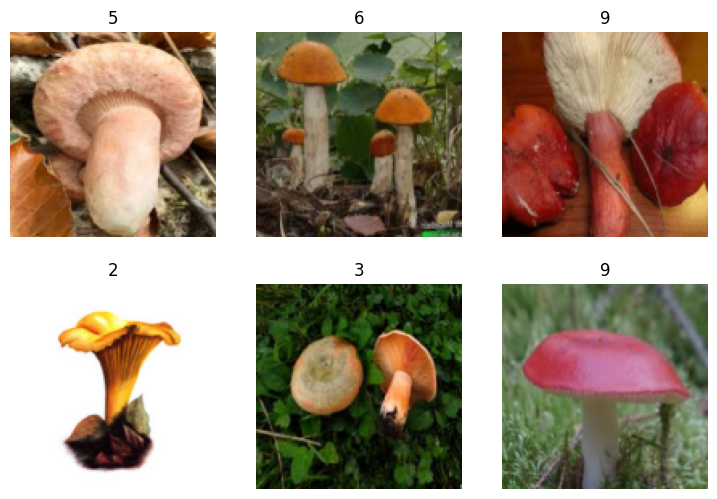

In [ ]:
dls = ImageDataLoaders.from_df(
    df,
    path=train_folder,
    folder='',
    valid_pct=0.2,
    item_tfms=Resize(280, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
)
dls.show_batch(max_n=6)

We're going to start with `convnext_tiny_in22k`, which I picked using this [Kaggle notebook](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning). It's got decent accuracy but its also one of the faster models, which is critical for rapid iteration.

By converting to **half-precision floating point** (FP16) with `to_fp16()` we can use half the memory, allowing larger batch sizes and faster training. It should preserve enough precision, but it is a slight trade-off for speed. We use the `path` parameter to specify the directory where FastAI stores temporary files and the model (if we choose to save it).

We use `lr_find()` which helps us to pick a suitable learning rate. We will pick a learning rate that is a little less conservative then the recommendations made.

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0010000000474974513, slide=0.0020892962347716093)

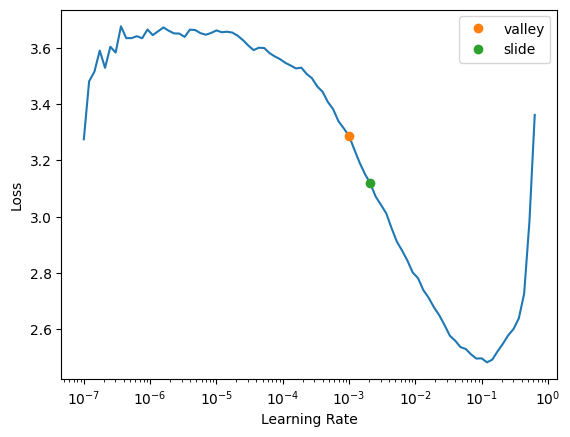

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

learn.fine_tune(8, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.438459,1.281309,0.334038,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.422320,1.050042,0.287526,00:09
1,0.345484,1.070490,0.281184,00:11
2,0.349287,1.103902,0.276956,00:10
3,0.311659,0.957870,0.243129,00:09
4,0.253792,0.939146,0.245243,00:11
5,0.200882,0.912295,0.230444,00:11
6,0.151550,0.887981,0.224101,00:10
7,0.127783,0.885627,0.219873,00:10


Now that we have trained our baseline model, let's submit our predictions to Kaggle.

First, we need to check the format using the sample submission.

In [ ]:
pd.read_csv(comp + '/sample_submission.csv').head()

,Id,Predicted
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


We can make our predictions and submit to Kaggle, following the formatting above.

We want a dataloader that is exactly like the dataloader we used to train the model, except pointing at the test set. It will use exactly the same transformations. For this, we use the `test_dl()` function from FastAI, which has a key difference to a normal dataloaders - it doesn't contain any labels.

The `with_decoded` parameter will return not only the logit for each image, but also calculate the index of the most likely. The `_` represents the targets, which are empty since we are using a test set.



In [ ]:
test_files = sorted(get_image_files(test_folder))
test_dl = dls.test_dl(test_files)
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
sub_df = pd.DataFrame({'Predicted':idxs})
sub_df['Id'] = range(0, len(sub_df))
sub_df = sub_df[['Id', 'Predicted']]

In [ ]:
sub_df.head()

,Id,Predicted
0,0,8
1,1,2
2,2,2
3,3,7
4,4,4


In [ ]:
sub_df.to_csv('subm.csv', index=False)

Our baseline model has an accuracy of 0.82 on the test set, which is pretty good, but puts us towards the bottom of the leaderboard. We will need to improve it to score higher.

## Improving Speed of Iteration

Because we are taking an **iterative approach** to deep learning we want to speed up our approach. This means encapsulating some of our code.

In [ ]:
resize_images(comp, dest='resized', max_size=256, recurse=True)